In [1]:
# Using cvxopt
# from cvxopt import matrix, solvers
# # Test on a linear program:
# A = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
# b = matrix([ 1.0, -2.0, 0.0, 4.0 ])
# c = matrix([ 2.0, 1.0 ])
# sol=solvers.lp(c,A,b)

In [2]:
import numpy as np
import cvxpy as cp # Use cvxpy instead
import matplotlib.pyplot as plt

In [3]:
# Loss Function:
def LS_Loss(X, Y, beta):
#     return cp.norm2(X @ beta - Y)**2
#     return 0.5*(cp.norm2(np.matmul(X,beta)-Y)**2)
    return 0.5*(cp.norm2(beta-Y)**2)

# One-Norm Regularization Term:
def One_Norm_Reg(beta):
    return cp.norm1(beta)

# LASSO Objective Function:
def LASSO(X, Y, beta, lambd):
    return LS_Loss(X, Y, beta) + lambd*One_Norm_Reg(beta)

# Fused LASSO Objective Function:
def Fused_LASSO(X, Y, beta, lambd):
    return LS_Loss(X, Y, beta) + lambd*One_Norm_Reg(beta[:-1]-beta[1:])

# Mean-squared error
def MSE(X, Y, beta):
    return (1.0 / X.shape[0]) * LS_Loss(X, Y, beta).value

In [12]:
# Load the Data:
text_file = open("y.txt", "r")
y = np.array(text_file.read().split('\n'))
# print(y)
N = np.shape(y)[0]
# print(N)

In [5]:
# Solve with lambda = 1
lambd = 1
X = np.identity(N)

beta = cp.Variable(N)
# lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(Fused_LASSO(X, y, beta, lambd)))

In [6]:
sln = problem.solve()
# beta.value
print('Optimal Objective Value =', np.round(sln,3))

Optimal Objective Value = 1.407


In [14]:
# Load true beta values:
text_file = open("beta0.txt", "r")
beta0 = np.array(text_file.read().split('\n'))
# print(beta0)
# print(np.shape(beta0)[0])

In [7]:
# Solve with lambda varying:

# 100 logarithmically spaced values from 10 to 10E−2
# linsp = np.log(np.linspace(np.exp(1E-2),np.exp(1E1),100))
# linsp2 = 1E1 - linsp + 1E-2

lambd_vals = np.logspace(np.log(1E1), np.log(1E-2), 100, base = 2.718281828)

In [53]:
beta = cp.Variable(N)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(Fused_LASSO(X, y, beta, lambd)))

train_error = []
test_error = []
beta_vals = []
for v in lambd_vals:
    lambd.value = v
    problem.solve()
    train_error.append(MSE(X, y, beta))
    test_error.append(MSE(X, beta0, beta))
    beta_vals.append(beta.value)

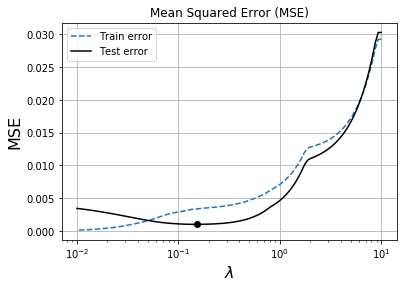

Optimal Lambda = 0.152
Minimum MSE = 0.001


In [60]:
x_min = lambd_vals[np.argmin(test_error)]
y_min = np.min(test_error)

def plot_MSE(train_error, test_error, lambd_vals):
    plt.plot(lambd_vals, train_error, '--', label="Train error")
    plt.plot(lambd_vals, test_error, 'k-', label="Test error")
    plt.plot(x_min,y_min, 'ko')
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.ylabel("MSE", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.grid()
    plt.show()

plot_MSE(train_error, test_error, lambd_vals)

print("Optimal Lambda =", round(x_min,3))
print("Minimum MSE =", round(y_min,3))

In [78]:
# Change points in beta_hat
chg_pts = np.zeros(N)
for i in np.arange(N):
    beta_hat = beta_vals[i]
    db = np.absolute(beta_hat[:-1] - beta_hat[1:])
    chg_pts[i] = np.shape(np.where(db > 1E-8))[1]

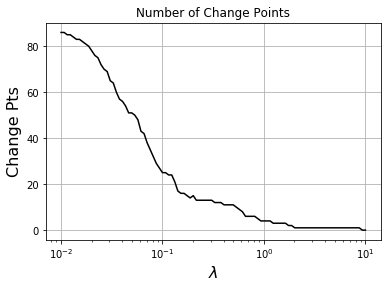

In [81]:
# Plot change points
def plot_Chg_Pts(lambd_vals, chg_pts):
    plt.plot(lambd_vals, chg_pts, 'k')
    plt.xscale("log")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.ylabel("Change Pts", fontsize=16)
    plt.title("Number of Change Points")
    plt.grid()
    plt.show()

plot_Chg_Pts(lambd_vals, chg_pts)